In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

import json
import numpy as np
import os
import cv2
import pickle
from tqdm import tqdm
import random
import time
from tensorflow.keras.callbacks import TensorBoard

from proto import *

In [3]:
IMAGE_SIZE = 50
img_path = r'..\..\ImageGenerator\Targets'
target_path = r'..\..\ImageGenerator\Target Data'

In [5]:
def create_training_data(image_path, json_path, img_size):
    training_data = []
    for img in tqdm(os.listdir(image_path)):
        img_array = cv2.imread(os.path.join(image_path, img), cv2.IMREAD_GRAYSCALE)
        # img_array = cv2.Canny(img_array, 50, 50)
        new_array = cv2.resize(img_array, (img_size, img_size))
        json_file = img[0:-4] + '.json'
        json_dict = json.load(open(os.path.join(json_path, json_file)))
        class_number = Shape[json_dict['shape']].value
        training_data.append([new_array, class_number])
    return np.array(training_data)
def store_training_data():
    X_data = []
    y_data = []
    shape_training_data = create_training_data(img_path, target_path, IMAGE_SIZE)
    for feature, label in shape_training_data:
        X_data.append(feature)
        y_data.append(label)

    X = np.array(X_data)
    X = X.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    y = np.array(y_data)

    pickle_out = open(r"Training_Data/shape_X.pickle", "wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()

    pickle_out = open(r"Training_Data/shape_y.pickle", "wb")
    pickle.dump(y, pickle_out)
    pickle_out.close()

In [6]:
def train_model():
    pickle_in = open("Training_Data/shape_X.pickle", 'rb')
    X = pickle.load(pickle_in)

    pickle_in = open("Training_Data/shape_y.pickle", 'rb')
    y = pickle.load(pickle_in)

    X = X/255.
    y = to_categorical(y)

    conv_layer = 2
    layer_size = 256
    dense_layer = 1
    dense_size = 128

    NAME = "{}-conv-{}-nodes-{}-dense-{}-nodes-{}".format(conv_layer,
                                                          layer_size,
                                                          dense_layer,
                                                          dense_size,
                                                          int(time.time()))

    model = Sequential()
    model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for l in range(conv_layer - 1):
        model.add(Conv2D(layer_size, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    for _ in range(dense_layer):
        model.add(Dense(dense_size))
        model.add(Activation('relu'))

    model.add(Dense(14))
    model.add(Activation('softmax'))

    tensorboard = TensorBoard(log_dir=r"shape_classifier_logs\{}".format(NAME))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
                  )

    model.fit(X, y,
              batch_size=32,
              epochs=4,
              validation_split=0.3,
              callbacks=[tensorboard])

    model.save('shape_classifier.model')

    return model

In [7]:
def load_model():
    return tf.keras.models.load_model('shape_classifier.model')

In [8]:
def prep_image(img):
    # img_array = cv2.Canny(img, 50, 50)
    img_array = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img_array

In [9]:
model = train_model()

Epoch 1/4
  1/329 [..............................] - ETA: 0s - loss: 2.6338 - accuracy: 0.0938WARNING:tensorflow:From C:\Users\hscot\anaconda3\envs\py37\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
329/329 [==============================] - 154s 467ms/step - loss: 1.4823 - accuracy: 0.4888 - val_loss: 0.5535 - val_accuracy: 0.8184
Epoch 2/4
329/329 [==============================] - 152s 461ms/step - loss: 0.3692 - accuracy: 0.8798 - val_loss: 0.2700 - val_accuracy: 0.9229
Epoch 3/4
329/329 [==============================] - 149s 454ms/step - loss: 0.1833 - accuracy: 0.9413 - val_loss: 0.2250 - val_accuracy: 0.9251
Epoch 4/4
329/329 [==============================] - 153s 465ms/step - loss: 0.1135 - accuracy: 0.9645 - val_loss: 0.1363 - val_accuracy: 0.9600
Instructions for updating:
This property sho

In [12]:
class Shape(Enum):
    Circle = 1
    Semicircle = 2
    Quarter_Circle = 3
    Triangle = 4
    Square = 5
    Rectangle = 6
    Trapezoid = 7
    Pentagon = 8
    Hexagon = 9
    Heptagon = 10
    Octagon = 11
    Star = 12
    Cross = 13

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


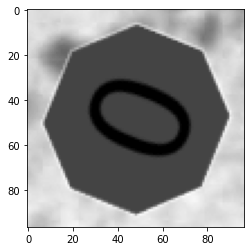

In [11]:
loaded_model = load_model()
img = cv2.imread('../../ImageGenerator/Targets/1000.png', cv2.IMREAD_GRAYSCALE)
old_img = img
img = prep_image(img)
img = np.array(img)
img = np.expand_dims(img, -1)
arr = np.array([img])
predictions = loaded_model.predict(arr)
print(predictions[0])
import matplotlib.pyplot as plt
plt.imshow(old_img, cmap=plt.cm.binary)